In [1]:
import jax.numpy as jnp
from jax import jacfwd
from utils_v2 import KalmanFilter
from typing import Tuple
import math
import matplotlib.pyplot as plt
import jax.random as jrandom
from time import time

In [48]:
sigma_x = 0.01
sigma_t = 0.01
N = int(1 / sigma_x)
M = N * 2
x_values = jnp.arange(0, 1, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
v = 0.001

In [49]:
u = jnp.sin(x_values * 2 * math.pi)
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)

In [50]:
x_0 = jnp.expand_dims(jnp.r_[u, f, u, f, nu], axis=-1)

In [51]:
A = -2 * jnp.ones(u.shape[0])
A = jnp.diag(A)
A += jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
A /= sigma_x**2


In [52]:
B = jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
B /= 2 * sigma_x


In [53]:
INVS = jnp.linalg.inv(jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A)

In [54]:
def new_u(
    u: jnp.ndarray, f: jnp.ndarray, prev_u: jnp.ndarray, prev_f: jnp.ndarray, v: float
) -> jnp.ndarray:
    new_u = INVS
    temp = (jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A) @ u

    temp -= sigma_t * B @ (1.5 * u**2 - 0.5 * prev_u**2)
    temp += sigma_t * (1.5 * f - 0.5 * prev_f)
    new_u @= temp
    return new_u

In [55]:
def new_state(
    x_k: jnp.ndarray,
    __: jnp.ndarray = None,
) -> jnp.ndarray:
    start = 0
    end = u.shape[0]
    u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    f_k = x_k[start:end]
    start += u.shape[0]
    end += u.shape[0]
    prev_u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    prev_f_k = x_k[start:end]
    nu = x_k[end:]

    new_x = jnp.r_[new_u(u_k, f_k, prev_u_k, prev_f_k, v), f_k, u_k, f_k, nu]
    return new_x

In [66]:
class ExtendedKalmanFilter(KalmanFilter):
    def __init__(
        self,
        x_0: jnp.ndarray | float | int,
        f: callable,
        h: callable,
        R: jnp.ndarray,
        Q: jnp.ndarray,
        Z: jnp.ndarray,
        w_k: jnp.ndarray,
        P_0: jnp.ndarray,
        jaccobian_f: callable = None,
        jaccobian_h: callable = None,
    ) -> None:
        if not isinstance(x_0, (jnp.ndarray, float, int)):
            raise Exception(
                "The State input must be of type jnp.ndarray, float, or int"
            )
        # Expand scalar state into array if necessary
        x_0 = jnp.expand_dims(x_0, axis=-1) if type(x_0) in (int, float) else x_0
        super().__init__(x_0, None, None, None, None, R, Q, Z, w_k, P_0)
        if jaccobian_f is not None:
            self._function_f = jaccobian_f
            self._set_matrix_f = self._set_none
            self.A = self._function_f(self.x_k)

        else:
            self._set_matrix_f = self._matrix_f

        self.f = f  # Nonlinear state transition function: f(x, u)

        if jaccobian_h is not None:
            self._function_h = jaccobian_h
            self._set_matrix_h = self._set_none
            self.H = self._function_h(self.x_k)
        else:
            self._set_matrix_h = self._matrix_h

        self.h = h  # Nonlinear measurement function: h(x)
    def _verify_matrices(self):
        """
        Verify that all matrices and vectors have the correct shapes.

        Returns:
            bool: True if all shapes are valid.

        Raises:
            RuntimeError: If any matrix or vector does not match the expected shape.
        """
        x_0_shape = self.x_0.shape[0]
        if self.R.shape[0] != self.R.shape[1] or self.R.shape[0] != self.C.shape[0]:
            raise RuntimeError(
                f"The Measurement noise covariance R must be a square matrix with shape ({self.H.shape[0]}, {self.H.shape[0]}), got {self.R.shape}!"
            )
        if self.Q.shape[0] != self.Q.shape[1] or self.Q.shape[0] != x_0_shape:
            raise RuntimeError(
                f"The Process noise covariance Q must be a square matrix with shape ({x_0_shape}, {x_0_shape}), got {self.Q.shape}!"
            )
        if self.Z.shape != (self.H.shape[0], 1):
            raise RuntimeError(
                f"The Measurement noise Z must be a column vector with shape ({self.H.shape[0]}, 1), got {self.Z.shape}!"
            )
        if self.w_k.shape != (self.A.shape[0], 1):
            raise RuntimeError(
                f"The Process noise vector w_k must be a column vector with shape ({x_0_shape}, 1), got {self.w_k.shape}!"
            )
        if self.P_0.shape != self.A.shape:
            raise RuntimeError(
                f"The Initial error covariance P_0 must be a square matrix with shape ({x_0_shape}, {x_0_shape}), got {self.P_0.shape}!"
            )
        return True
    def _set_none(self, u_k: jnp.ndarray = None) -> None:
        pass

    def _jacobian(
        self, f: callable, x: jnp.ndarray, u: jnp.ndarray = None
    ) -> jnp.ndarray:
        """
        Compute the full Jacobian of a vector-valued function f at x.
        """
        jac_F = jacfwd(f)  # Forward-mode Jacobian
        return jnp.array(jac_F(x)) if u is None else jnp.array(jac_F(x, u))

    def _matrix_f(self, x, u):
        return self._jacobian(self.f, x, u)  # State transition Jacobian

    def _matrix_h(self, x):
        return self._jacobian(self.h, x)  # Measurement Jacobian

    def _step_estimation(self, u_k: jnp.ndarray) -> jnp.ndarray:
        """
        Predicts the next state using the nonlinear system dynamics f and control input u_k.

        Args:
            u_k: Control input vector (m x 1)

        Returns:
            Predicted state vector (n x 1)

        Raises:
            RuntimeError: If an error occurs during the prediction.
        """

        try:
            self._set_matrix_f(u_k)
            self._set_matrix_h()
            new_x_k = self.f(self.x_k, u_k) + self.w_k
            return new_x_k
        except Exception as e:
            raise RuntimeError(f"Error in EKF step estimation:{e}") from e

    def _current_state_and_process(
        self, x_km: jnp.ndarray
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Updates the state estimate using a measurement and the Kalman gain.

        This function recomputes the linearization matrices A and H based on the current state.

        Args:
            x_km: Noisy measurement vector (p x 1)

        Returns:
            A tuple containing:
            - Corrected state estimate (n x 1)
            - Updated error covariance matrix (n x n)

        Raises:
            RuntimeError: If an error occurs during state update.
        """
        try:
            # Recompute linearization at current state
            self.A = self._function_f(self.x_k)
            self.H = self._function_h(self.x_k)
            x_k = self.x_k + self.K @ (x_km - self.h(self.x_k) + self.Z)
            p_k = (jnp.eye(self.K.shape[0]) - self.K @ self.H) @ self.P
            return x_k, p_k
        except Exception as e:
            raise RuntimeError(f"Error in EKF state and process update:{e}") from e

In [67]:
def jaccobian_f(x_k: jnp.ndarray) -> jnp.ndarray:
    Fuu = (
        jnp.eye(A.shape[0])
        + 0.5 * sigma_t * v * A
        - 3 * B @ jnp.diag(x_k[: A.shape[0]].squeeze()) * sigma_t
    )
    Fuu += 0.5 * B @ jnp.diag(x_k[A.shape[0] : 2 * A.shape[0]].squeeze()) * sigma_t
    Fuu @= INVS

    eye = jnp.eye(f.shape[0])
    zero = jnp.zeros(A.shape)

    Fuf = jnp.eye(f.shape[0]) * sigma_t

    F = jnp.block(
        [
            [Fuu, Fuf, zero, zero, zero],
            [zero, eye, zero, zero, zero],
            [zero, zero, eye, zero, zero],
            [zero, zero, zero, eye, zero],
            [zero, zero, zero, zero, eye],
        ]
    )
    return F

In [68]:
def h(x_k: jnp.ndarray) -> jnp.ndarray:
    block = jnp.block(
        [
            jnp.eye(A.shape[0]),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
        ]
    )
    return block @ x_k


In [69]:
def jaccobian_h(x_k: jnp.ndarray) -> jnp.ndarray:
    block = jnp.block(
        [
            jnp.eye(A.shape[0]),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
            jnp.zeros(A.shape),
        ]
    )
    return block


In [ ]:
R = jnp.eye(u.shape[0]) * 0.05
Q = jnp.eye(5 * u.shape[0]) * 0.05
P_0 = jnp.eye(5 * u.shape[0])

In [71]:
def plot(ekf: ExtendedKalmanFilter, iterations: int, plot_each: int = None) -> None:
    plot_each = iterations if plot_each is None else plot_each
    plot_each = min(plot_each, iterations)
    fig, ax = plt.subplots()
    ax.plot(x_values, x_0[:N], label="True state")
    for i in range(1, iterations + 1):
        ekf.predict(jnp.zeros((u.shape[0], u.shape[0])))
        ekf.update(x_0[:N])
        if i % plot_each == 0:
            ax.plot(x_values, ekf.x_k[:N], label=f"EKF estimation after {i} iterations")

    plt.xlabel("x_n values", fontsize=15)
    plt.ylabel("u_n values", fontsize=15)
    plt.title("Training evolution", fontsize=15)
    ax.legend(fontsize=15)
    fig.set_size_inches(17, 10, forward=True)
    plt.show()


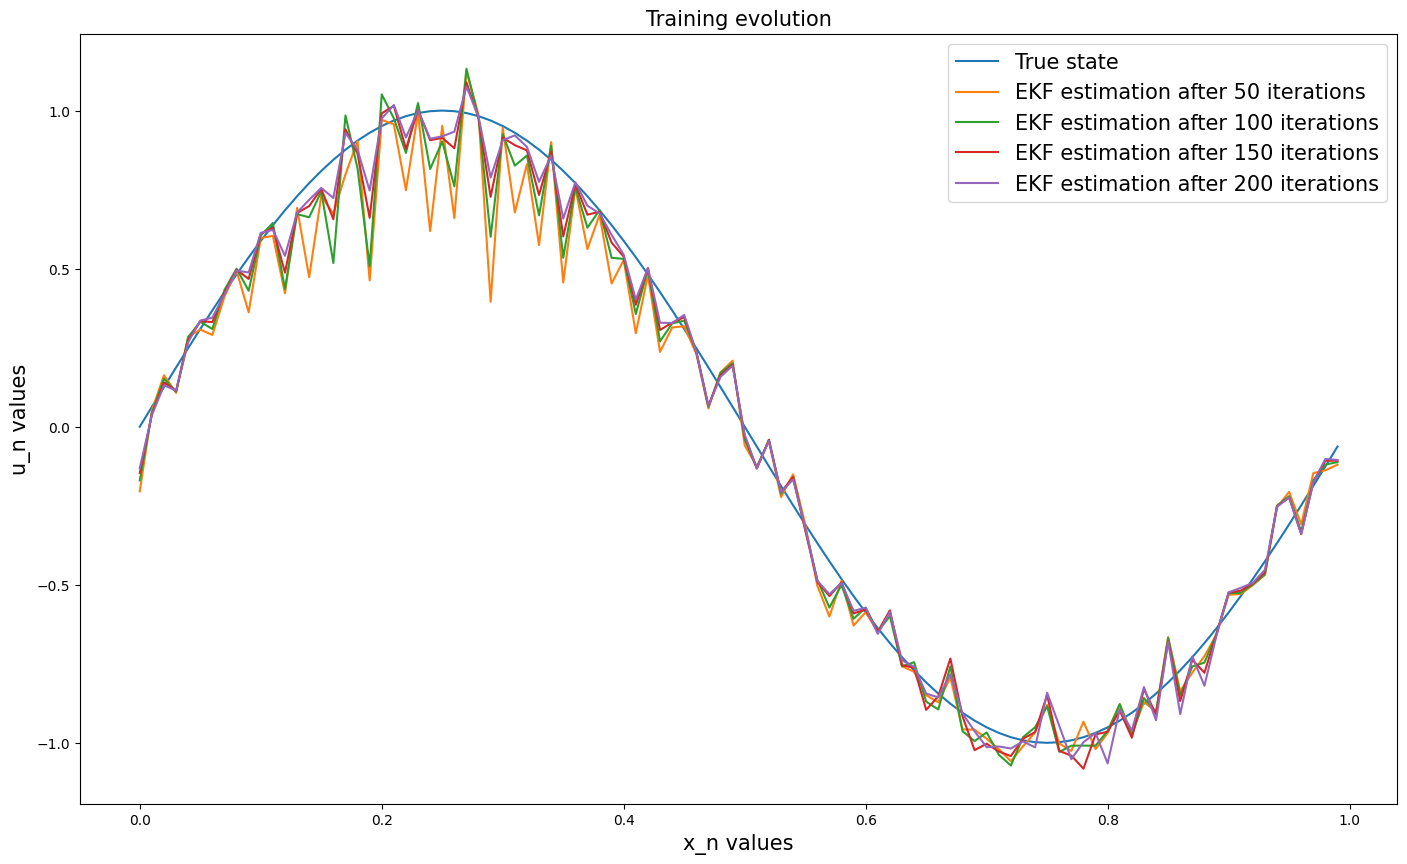

In [74]:
key = jrandom.PRNGKey(int(time()))
mean = 0
std_dev = 0.05
w_k = jrandom.normal(key, shape=(5 * A.shape[0], 1)) * std_dev + mean
Z = jrandom.normal(key, shape=(A.shape[0], 1)) * std_dev + mean
ekf = ExtendedKalmanFilter(
    x_0, new_state, h, R, Q, Z, w_k, P_0, jaccobian_f, jaccobian_h
)
plot(ekf, iterations=200, plot_each=50)